# Proyecto CDS (Clasificación/Detección/Segmentación)
Proyecto realizado para la asignatura 21781 - Aprendizaje Automático de la Universidad de las Islas Baleares

El siguiente proyecto ha sido realizado por:
- Rubén Ramis Martínez: ruben.ramis1@estudiant.uib.eu
- Emilio Salvador Fuster: emilio.salvador1@estudiant.uib.eu

# Introducción

AQUI PODEMOS HACER LA INTRODUCCIÓN DE LA PRÁCTICA (ORGANICEMOS UN POCO EL FICHERO COMO SI FUESE LA DOCUMENTACIÓN FINAL)

# Librerias
En la siguiente sección nos centraremos en los imports que se usarán.

In [1]:
!pip install ultralytics
# Necesario tener la librería "gdown" para importar los datos
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
import torch
from torch import nn
import torch.optim as optim
from tqdm import tqdm

from torchvision import datasets, models, transforms
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2 as T
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET

from torchvision.models import resnet50, ResNet50_Weights
from ultralytics import YOLO, SAM


import cv2
import numpy as np
from matplotlib import pyplot as plt
import os
from tempfile import TemporaryDirectory
import time

# Datos

Explicación de los datos que se van a usar.

Importación de los datos
Transformación
Train test
BACH

In [3]:
DOWNLOAD = True
BATCH_SIZE = 64

transform = transforms.Compose([
    transforms.Lambda(lambda x: x.expand(3, -1, -1) if x.size(0) == 1 else x),
    T.ToDtype(torch.float, scale=True),
    transforms.Resize((224, 224)),
    T.ToPureTensor()
])

In [4]:
class DatasetCaltech(Dataset):
    def __init__(self, root, target_class, transforms=None):
        self.root = root
        self.transforms = transforms

        # Lista de todas las subcarpetas dentro de '101_ObjectCategories'
        self.classes = sorted(os.listdir(os.path.join(root, "101_ObjectCategories")))

        # Asegurarse de que la clase objetivo esté en el dataset
        if target_class not in self.classes:
            raise ValueError(f"La clase {target_class} no se encuentra en el dataset.")

        # Crear una lista de las imágenes y sus etiquetas de clase
        self.imgs = []
        self.labels = []

        # Iterar sobre todas las clases
        for class_name in self.classes:
            class_img_path = os.path.join(self.root, "101_ObjectCategories", class_name)

            # Lista de imágenes dentro de la subcarpeta de cada clase
            img_files = sorted(os.listdir(class_img_path))

            # Establecer la etiqueta: 1 si es la clase objetivo, 0 si no lo es
            label = 1 if class_name == target_class else 0

            # Asociar las imágenes con su etiqueta (1 para la clase seleccionada, 0 para las demás)
            for img_file in img_files:
                self.imgs.append(os.path.join(class_name, img_file))
                self.labels.append(label)

    def __getitem__(self, idx):
        # Cargar la imagen
        img_path = os.path.join(self.root, "101_ObjectCategories", self.imgs[idx])
        img = read_image(img_path)

        # Obtener la etiqueta de la clase
        label = self.labels[idx]
        label = float(label)

        # Aplicar las transformaciones si se proporcionan
        if self.transforms is not None:
            img = self.transforms(img)

        return img, label

    def __len__(self):
        return len(self.imgs)
    

In [5]:
def collate_fn(batch):
    # Separamos las imágenes y las etiquetas
    images, labels = zip(*batch)
    
    # Apilamos las imágenes en un tensor (deberían ser tensores de la misma dimensión)
    images = torch.stack(images, dim=0)
    
    # Convertimos las etiquetas en un tensor
    labels = torch.tensor(labels, dtype=torch.float32)
    
    return images, labels

In [6]:
dataset = DatasetCaltech("../data/caltech101","watch", transforms=transform)
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn
)
dataset_size = len(dataset)

In [7]:
img, target = next(iter(data_loader))
print(img.shape, target)

torch.Size([64, 3, 224, 224]) tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Imagen 1230 - Etiqueta: 0.0


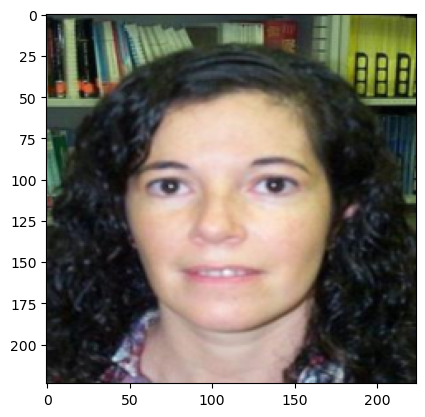

In [8]:
img, label = dataset[1230]
print(f"Imagen {1230} - Etiqueta: {label}")
plt.imshow(img.permute(1, 2, 0))  # Si quieres visualizar la imagen con matplotlib
plt.show()

# Modelos
A continuación, se explicarán los diferentes modelos que se usarán tanto para clasificación, detección y segmentación. Además, se implementarán y inicializarán.

## Clasificación

ALGO DE TEXTO

### Modelo AlexNet
Cargamos el modelo de AlexNet

In [9]:
modelo_AlexNet = models.alexnet(weights=True)
print(modelo_AlexNet)

C:\Users\Ramien\anaconda3\envs\AA\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Realizamos cambios en el clasificador, no nos interesa realizar nada nuevo para poder hacer comparaciones más justas. Solo cambiaremos la salida de 1000 a 1 (ya que son 2 clases).

In [10]:
modelo_AlexNet.classifier = nn.Sequential(
    nn.Dropout(p = 0.5),
    torch.nn.Linear(9216,4096),
    nn.ReLU(inplace=True),
    nn.Dropout(p = 0.5),
    torch.nn.Linear(4096,4096),
    nn.ReLU(inplace=True),
    torch.nn.Linear(4096,1)
)
print(modelo_AlexNet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

### Modelo RestNet

In [11]:
modelo_RestNet = models.resnet50(weights=True)
print(modelo_RestNet)

C:\Users\Ramien\anaconda3\envs\AA\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Realizamos cambios en el clasificador, no nos interesa realizar nada nuevo para poder hacer comparaciones más justas. Solo cambiaremos la salida de 1000 a 1 (ya que son 2 clases).

In [12]:
modelo_RestNet.fc = torch.nn.Linear(2048,1)
print(modelo_RestNet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Modelo VGG26

In [13]:
modelo_vgg16 = models.vgg16(weights=True)
print(modelo_vgg16)

C:\Users\Ramien\anaconda3\envs\AA\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Realizamos cambios en el clasificador, no nos interesa realizar nada nuevo para poder hacer comparaciones más justas. Solo cambiaremos la salida de 1000 a 1 (ya que son 2 clases).

In [14]:
modelo_vgg16.classifier = nn.Sequential(
    torch.nn.Linear(25088,4096),
    nn.ReLU(inplace=True),
    nn.Dropout(p = 0.5),
    torch.nn.Linear(4096,4096),
    nn.ReLU(inplace=True),
    nn.Dropout(p = 0.5),
    torch.nn.Linear(4096,1)
)
print(modelo_vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Propio: Modelo RubEmNet
En este aparado se desarrollará un modelo desde 0. La idea es crear un modelo pequeño pero que al mismo tiempo de buenos resultados de clasificación.

In [15]:
class RubEmNet(nn.Module):
    def __init__(self):
        super(RubEmNet, self).__init__()
        
        # Extractor de características
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.ReLU(inplace=True), 

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(256, 512, kernel_size=3, padding=1),  # Reducido de 1024 a 512
            nn.BatchNorm2d(512),
            nn.MaxPool2d(kernel_size=2, stride=2),
        
            nn.ReLU(inplace=True),
        
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
        )
        
        # Promedio global
        self.avgpool = nn.AdaptiveAvgPool2d((2, 2))  # Cambia el tamaño a 2x2
        
        # Clasificador
        self.classifier = nn.Sequential(
            nn.Linear(1024 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

Cargamos el modelo

In [16]:
modelo_RubEmNet = RubEmNet()
print(modelo_RubEmNet)

RubEmNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): MaxPool2d

## Detección
De por si Caltech101 no incluye bounding boxes, para ello haciendo uso de Label-Studio nos encargaremos de generar únicamente las bounding boxes de nuestra clase. Únicamente lo haremos la clase que nos corresponde que es ... ya que solo nos interesa dectectar esos objetos.

Los datos se exportarán en formato COCO de esta manera ya se asegura la compatibilidad con ultralytics.

### Modelo YOLO
Para el modelo de YOLO haremos uso de la último versión diponible en ultralytics. Se trata de [YOLO11](https://docs.ultralytics.com/models/yolo11/).

In [17]:
# Elegir el modelo que mejor se adapte al dispositivo
YOLO_11_BASE = "yolo11n.pt"
YOLO_11_PEQUENO = "yolo11m.pt"
YOLO_11_ENORME = "yolo11x.pt"

#Al usar una RTX-3060 haremos uso del modelo más grande que ofrecen.
modelo_YOLO_deteccion = YOLO(YOLO_11_ENORME)

### Modelo SAM
Para el modelo SAM haremos uso de la última versión que se puede obtener de ultralytics. Se trata de [SAM2](https://docs.ultralytics.com/models/sam-2/), concretamente la versión 2.1.

In [18]:
# Elegir el modelo que mejor se adapte al dispositivo
SAM_2_1_BASE = "sam2.1_b.pt"
SAM_2_1_PEQUENO = "sam2.1_s.pt"
SAM_2_1_ENORME = "sam2.1_l.pt"

#Al usar una RTX-3060 haremos uso del modelo más grande que ofrecen.
modelo_SAM = SAM(SAM_2_1_ENORME)

## Segmentación
De por si Caltech101 no incluye mascaras de segmentación, para ello haciendo uso de Label-Studio nos encargaremos de generar únicamente las mascaras de segmentación de nuestra clase. Únicamente lo haremos la clase que nos corresponde que es ... ya que solo nos interesa dectectar esos objetos.

Los datos se exportarán en formato COCO de esta manera ya se asegura la compatibilidad con ultralytics.

### Modelo YOLO

In [19]:
# Elegir el modelo que mejor se adapte al dispositivo
YOLO_11_SEG_BASE = "yolo11n-seg.pt"
YOLO_11_SEG_PEQUENO = "yolo11m-seg.pt"
YOLO_11_SEG_ENORME = "yolo11x-seg.pt"

#Al usar una RTX-3060 haremos uso del modelo más grande que ofrecen.
modelo_YOLO_segmentacion = YOLO(YOLO_11_SEG_ENORME)

### Modelo SAM

No inicializaremos el modelo de SAM otra vez, la "ventaja" de SAM sobre YOLO es que un modelo que ya permite definir bounding boxes y segementar imagenes en un solo modelo. La principal ventaja de YOLO sobre SAM en este termino que es que cada modelo está más optimizado para la tarea a realizar.

# Clasificación
Apartado centrado en clasificación

## Congelación de pesos
Es importante congelar los pesos del extractor de características para ...


In [20]:
# Congelación de pesos de AlexNet
for param in modelo_AlexNet.features.parameters():
   param.requires_grad = False

# Congelación de pesos de AlexNet de ResNet
for param in modelo_RestNet.parameters():
    param.requires_grad = False
# Descongelar las capas del clasificador
for param in modelo_RestNet.fc.parameters():
    param.requires_grad = True

#Congelación de pesos de VGG16
for param in modelo_vgg16.features.parameters():
   param.requires_grad = False

## Definimos la función de entrenamiento
La siguiente función se puede obtener de [pytorch](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html). La hemos elegido porque nos ha resultado muy interesante como lo plantea. Además, permite guardar en el proceso el modelo con sus pesos y podemos obtener el tiempo de entrenamiento.

Hemos eliminado el parametros scheduler ya que no nos interesa ajustar dinámicamente la tasa de aprendizaje.

In [21]:
def train_model(model, criterion, optimizer, num_epochs=25):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Realizando entrenamiento de {model.__class__.__name__} en el dispositivo {device}")
    model = model.to(device)
    pbar = tqdm(range(1, num_epochs + 1))
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in pbar:
            print(f'Epoch {epoch}/{num_epochs}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                for inputs, labels in data_loader:
                    inputs = inputs.to(device)
                    labels = labels.to(device).view(-1, 1)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                epoch_loss = running_loss / dataset_size
                epoch_acc = running_corrects.double() / dataset_size

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))

    model_dir = "models"
    os.makedirs(model_dir, exist_ok=True)
    
    # Construir la ruta final del modelo
    permanent_model_path = os.path.join(model_dir, f"best_model_{model.__class__.__name__}.pth")

    torch.save(model.state_dict(), permanent_model_path)

    print(f"Modelo guardado en: {permanent_model_path}")

    torch.cuda.empty_cache()

    return model

## Entrenamiento
Una vez que definido la función de entrenamiento estamos preparados para comenzar el entrenamiento de los modelos propios con los nuevos datos.

In [22]:
EPOCHS = 100
# Definimos el criterio
criterion = nn.BCEWithLogitsLoss()
# Ratio de aprendizaje
learning_rate = 1e-3  # Hiperparàmetre
# Definimos el optimizer
optimizer_AlexNet = optim.Adam(modelo_AlexNet.parameters(), lr=learning_rate)
optimizer_RestNet = optim.Adam(modelo_RestNet.parameters(), lr=learning_rate)
optimizer_vgg16 = optim.Adam(modelo_vgg16.parameters(), lr=learning_rate)
optimizer_RubEmNet = optim.Adam(modelo_RubEmNet.parameters(), lr=learning_rate)

#best_AlexNet = train_model(modelo_AlexNet,criterion,optimizer_AlexNet,EPOCHS)

In [23]:
#best_RestNet = train_model(modelo_RestNet,criterion,optimizer_RestNet,EPOCHS)

In [24]:
#best_vgg16 = train_model(modelo_vgg16,criterion,optimizer_vgg16,EPOCHS)

In [25]:
best_RubEmNet = train_model(modelo_RubEmNet,criterion,optimizer_RubEmNet,EPOCHS)

Realizando entrenamiento de RubEmNet en el dispositivo cuda


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Epoch 1/100
----------
train Loss: 0.6167 Acc: 62.2853


  1%|▊                                                                               | 1/100 [01:17<2:08:22, 77.81s/it]

val Loss: 0.1344 Acc: 62.2845

Epoch 2/100
----------


  1%|▊                                                                               | 1/100 [01:22<2:15:32, 82.15s/it]


KeyboardInterrupt: 

## Pruebas

## Evaluación

## Explicación de los resultados

## Conclusiones clasificación

## Almacenas pesos

# Detección
Apartado centrado en detección

## Entrenamiento

## Pruebas

## Evaluación

## Explicación de los resultados

## Conclusiones detección

## Almacenas pesos

# Segmentación
Apartado centrado en segmentación

## Entrenamiento

## Pruebas

## Evaluación

## Explicación de los resultados

## Conclusiones segmentación

## Almacenas pesos

# Conclusiones finales